# **Predicting Customer Satisfaction**
## *Given survey data from an Airline, can we predict the satisfaction of a customer? *
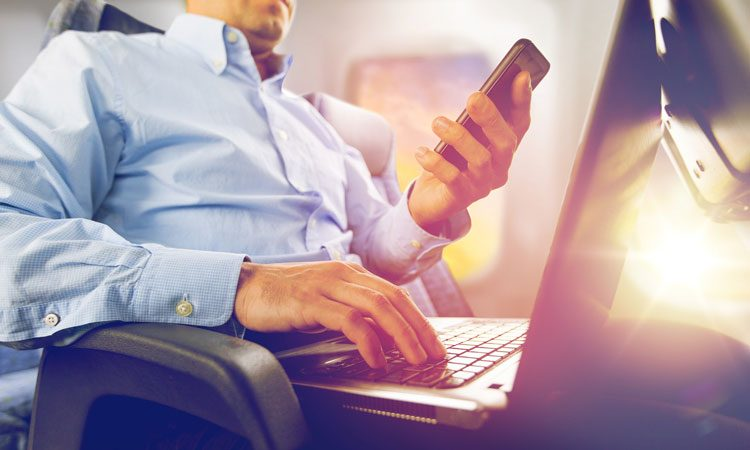

Welcome! This kernels aim is to showcase a few of the basics of data science (data cleaning, encoding, feature engineering, and model training), all while attempting to solve a problem that is common among businesses: *Customer Satisfaction*. 

We will be treating this as a binary classification problem, where we will attemp to create a model that predicts whether a customer was **Satisfied** or **Unsatisfied** with the experience and/or service which an airline provided.

**If you find this kernel helpful, please UPVOTE**

V10 - Fixed bug where test data was being set to train data

V9 - Initial Public Kernel


### Notes about the Dataset
This dataset has already been split into train and test csv files. 80% of the total dataset is in train.csv and 20% is in test.csv

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, plot_confusion_matrix, classification_report
from scipy import stats

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
directory = "/kaggle/input/airline-passenger-satisfaction/"
feature_tables = ['train.csv', 'test.csv']

df_train = directory + feature_tables[0]
df_test = directory + feature_tables[1]

# Create dataframes
print(f'Reading csv from {df_train}...')
train = pd.read_csv(df_train)
print('...Complete')

print(f'Reading csv from {df_train}...')
test = pd.read_csv(df_test)
print('...Complete')

In [ ]:
train.head()

## Clean and Transform Dataset
Based on the training data above, there are several things we need to do in order to prepare the data for use in a model. There are several catagorical variables that need to be encoded, including our target variable 'Satisfaction'. There are also a couple of columns that are unnecessary, such as 'Unnamed:0' and 'id'. We can drop these. The functions below will be used to perform the dataset preparation.

In [ ]:
def transform_gender(x):
    if x == 'Female':
        return 1
    elif x == 'Male':
        return 0
    else:
        return -1
    
def transform_customer_type(x):
    if x == 'Loyal Customer':
        return 1
    elif x == 'disloyal Customer':
        return 0
    else:
        return -1
    
def transform_travel_type(x):
    if x == 'Business travel':
        return 1
    elif x == 'Personal Travel':
        return 0
    else:
        return -1
    
def transform_class(x):
    if x == 'Business':
        return 2
    elif x == 'Eco Plus':
        return 1
    elif x == 'Eco':
        return 0    
    else:
        return -1
    
def transform_satisfaction(x):
    if x == 'satisfied':
        return 1
    elif x == 'neutral or dissatisfied':
        return 0
    else:
        return -1
    
def process_data(df):
    df = df.drop(['Unnamed: 0', 'id'], axis = 1)
    df['Gender'] = df['Gender'].apply(transform_gender)
    df['Customer Type'] = df['Customer Type'].apply(transform_customer_type)
    df['Type of Travel'] = df['Type of Travel'].apply(transform_travel_type)
    df['Class'] = df['Class'].apply(transform_class)
    df['satisfaction'] = df['satisfaction'].apply(transform_satisfaction)
    df['Arrival Delay in Minutes'].fillna(df['Arrival Delay in Minutes'].median(), inplace = True)
    
    return df

train = process_data(train)
test = process_data(test)

In [ ]:
train.head()

Nice! We now have every feature properly coded, almost time to start creating some models! But first, we will want to normalize our dataset via StandardScaler. Even if the model you are using does not care about a normalized dataset, I still like to do it just out of routine.

In [ ]:
#Define our features and target (this is helpful in case you would like to drop any features that harm model performance)
features = ['Gender', 'Customer Type', 'Age', 'Type of Travel', 'Class',
       'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
target = ['satisfaction']

# Split into test and train
X_train = train[features]
y_train = train[target].to_numpy()
X_test = test[features]
y_test = test[target].to_numpy()

# Normalize Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Normalization Complete! Also, just for kicks, lets take a look at a correlation heatmap to see which features correlate well with customer satisfaction.
* **Best features** - Online Booking, Class, and Type of Travel
* **Worst features** - Gate location, Gender, and Departure/Arrival Time Convenient

We will keep all of our features in for now, but can always return to this step in case we want to drop features.

In [ ]:
corr = train.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

## Model Evaluation

Now to the models! We will be trying out a few different models to see which one is the best choice for our problem. I have created a small function below which will train, predict, and evaluate all of our models. We will be evaluating performance of our models with the ROC_AUC metric. This metric is good for classification of a dataset which a relatively balance dataset in terms of our target. We will also be looking at the confusion matrix for our model to best understand how our model is mischaracterizing predictions (Are we seeing majority false positives? etc.) 

Note that I did some hyperparameter tuning on some of the models, but not all. I will be publishing another kernel showing how to tune hyperparameters, so stay tuned!

In [ ]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    
    return model, roc_auc

### Random Forest 

A great place to start! We are seeing an accuracy of 96.30%. Lets see if the other models can compare.

In [ ]:
params_rf = {'max_depth': 25,
         'min_samples_leaf': 1,
         'min_samples_split': 2,
         'n_estimators': 1200,
         'random_state': 42}

model_rf = RandomForestClassifier(**params_rf)
model_rf, roc_auc_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

### LightGBM

Not bad LightGBM! But not quite up at 'Random Forest' levels. Lets keep going!

In [ ]:
params_lgb ={'colsample_bytree': 0.85, 
         'max_depth': 15, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, roc_auc_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

### Catboost

Pretty good for not having tuned hyperparameters here. Expect a performance boost once that is completed.

In [ ]:
params_cb ={}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, roc_auc_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

### XGBoost

I expected more from you XGBoost ;)

In [ ]:
params_xgb ={}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, roc_auc_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

## Model Comparison and Conclusions

Based on the roc_auc metric, we have a clean winner. Our Random forest classifier outperformed all of our other models. One thing to keep in mind is that both the Catboost and the XGBoost classifiers just used default parameters without any hyperparameter tuning. 

In [ ]:
auc_scores = [roc_auc_rf, roc_auc_lgb, roc_auc_cb, roc_auc_xgb]
model_scores = pd.DataFrame(auc_scores, index=['Random Forest','LightGBM','Catboost','XGBoost'], columns=['AUC'])
model_scores.head()

## Can you improve on my best models performance? What factors led instances of mis-classification? Try new things!

## UPVOTE if you found this helpful, insightful, intriquing, interesting, or other adjectives!